## Họ tên: Nguyễn Phú Thành - MSSV: 18110014
## Bài tập thực hành Nhập môn máy học - Lab 05

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist as pairwiseDist
from sklearn.model_selection import train_test_split

In [2]:
class KMeansCluster:
    def __init__(self, number_clusters = None):
        self.number_clusters = number_clusters 
    
    def __getDistanceMatrix__(self, X, clusters):
        '''
            Given K clusters (c_1, c_2,...,c_K) and n data points (x_1, x_2,...,x_n)
            where each data point is a row in X.
            Distance matrix (n, K) has the form:
                [
                    [d(x_1, c_1), d(x_1, c_2), ..., d(x_1, c_K)],
                    [d(x_2, c_1), d(x_2, c_2), ..., d(x_2, c_K)],
                    ...
                    [d(x_n, c_1), d(x_n, c_2), ..., d(x_n, c_K)]
                ]
        '''
        number_obsv, dimension = X.shape[:2]
        dist = [
            np.linalg.norm(X - cluster.reshape((1, dimension)), axis = 1)
            .reshape((number_obsv, 1)) for cluster in clusters
        ]
        return np.hstack(dist)
    
    def __getIndexCluster__(self, distanceMatrix):
        return distanceMatrix.argmin(axis = 1)
    
    def __WCV__(self, index_cluster, X):
        wcv = 0
        for i in np.unique(index_cluster):
            points_in_cluster = X[index_cluster == i]
            wcv += pairwiseDist(points_in_cluster).sum() * 1/points_in_cluster.shape[0]
        return wcv
    
    def fit(self, X, init_clusters = None, maxiter = 100, random_state = 0):
        number_obsv, dimension = X.shape[:2]
        
        #Initialize clusters centroid
        if init_clusters is None:
            # If not pre-assign, randomly choose K (number clusters) data points in X
            rnd = np.random.RandomState(random_state)
            shuffle_index = rnd.choice(np.arange(number_obsv), size = self.number_clusters, replace = False)
            self.clusters = X[shuffle_index].astype(float)
        else:
            # init_clusters must have the form (K, p), each row is a centroid in p-dimension
            assert init_clusters.shape == (self.number_clusters, dimension)
            self.clusters = init_clusters.copy()
        
        # Initial distance of each point to each cluster
        distance_matrix = self.__getDistanceMatrix__(X, self.clusters)
        # Initial label of each point
        index_cluster = self.__getIndexCluster__(distance_matrix)
        
        for _ in range(maxiter):
            # Update each centroid
            for i, centroid in enumerate(self.clusters):
                new_centroid = X[index_cluster == i].mean(axis = 0)
                # If new centroid doesn't change much from current centroid then quit
                if np.allclose(new_centroid, centroid):
                    return self.__WCV__(index_cluster, X)
                self.clusters[i, :] = new_centroid
            # Update distance of each point to each cluster and label of each point
            distance_matrix = self.__getDistanceMatrix__(X, self.clusters)
            index_cluster = self.__getIndexCluster__(distance_matrix)
        
        return self.__WCV__(index_cluster, X)

    def predict(self, X):
        # Predict label of one sample -> Reshape it into (1, p) matrix
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))
        distance_matrix = self.__getDistanceMatrix__(X, self.clusters)
        index_cluster = self.__getIndexCluster__(distance_matrix)
        return index_cluster

## 1. Hãy dùng thuật toán K-mean để chọn ra số cụm thích hợp (như trong slide bài giảng) dựa trên tập training, và dự đoán label của các quan sát trên tập testing của bộ dữ liệu bên dưới

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
X = data.iloc[:, [2, 3]].values

In [9]:
X_train, X_test = train_test_split(X, test_size = 0.33, random_state = 42)

In [10]:
number_clusters = [i for i in range(1, 11)]
WCVs = []
for k in number_clusters:
    mdl = KMeansCluster(number_clusters = k)
    wcv = mdl.fit(X_train, random_state = 42, maxiter = 1000)
    WCVs.append(wcv)

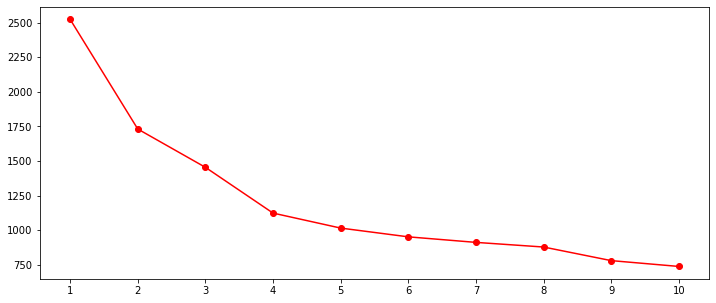

In [11]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(number_clusters, WCVs, marker = 'o', color = 'red')
_ = ax.set(xticks = number_clusters)

## Từ biểu đồ trên, ta chọn K = 4

In [12]:
mdl = KMeansCluster(number_clusters = 4)
_ = mdl.fit(X_train, random_state = 42, maxiter = 1000)

In [13]:
mdl.clusters

array([[ 37.5       , 103.81818182],
       [ 31.77272727,  71.70454545],
       [ 29.25      ,  28.6875    ],
       [ 56.46153846,  51.61538462]])

In [14]:
label_train = mdl.predict(X_train)

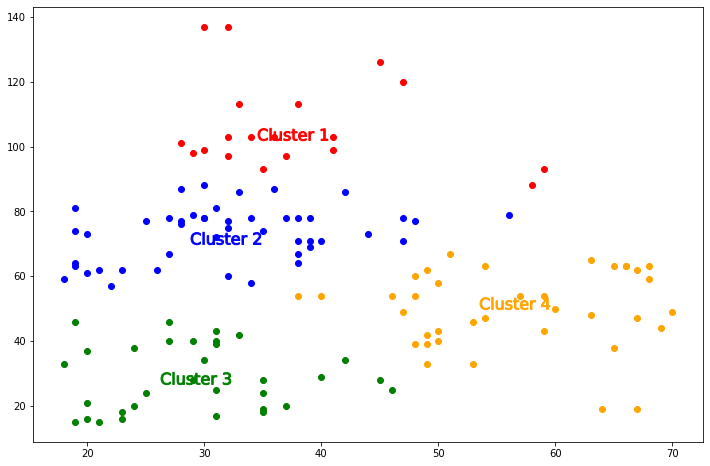

In [15]:
# Draw clusters for training dataset
fig, ax = plt.subplots(figsize = (12, 8))
color = ('red', 'blue', 'green', 'orange')
for id_label in np.unique(label_train):
    ax.scatter(
        X_train[label_train == id_label][:, 0], X_train[label_train == id_label][:, 1], 
        c = color[id_label]
    )
    ax.scatter(
        mdl.clusters[id_label][0], mdl.clusters[id_label][1],
        marker = f'Cluster ${id_label + 1}$',
        c = color[id_label], s = 5000
    )

## 2. Vẽ hình các cụm trên tập testing

In [16]:
label_test = mdl.predict(X_test)

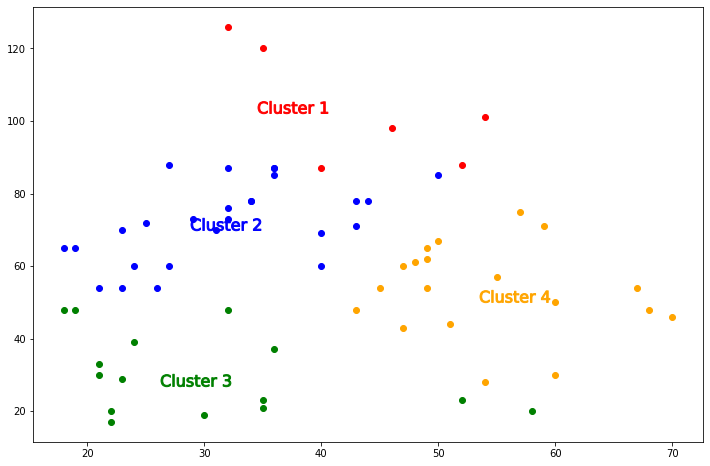

In [17]:
# Draw clusters for testing dataset
fig, ax = plt.subplots(figsize = (12, 8))
color = ('red', 'blue', 'green', 'orange')
for id_label in np.unique(label_test):
    ax.scatter(
        X_test[label_test == id_label][:, 0], X_test[label_test == id_label][:, 1], 
        c = color[id_label]
    )
    ax.scatter(
        mdl.clusters[id_label][0], mdl.clusters[id_label][1],
        marker = f'Cluster ${id_label + 1}$',
        c = color[id_label], s = 5000
    )